In [24]:
# Author: Matthew Green
# Date: 12/7/2017
# License: MIT

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

### Introduction

I downloaded a CSV of [City of Chicago employee salary data](https://data.cityofchicago.org/Administration-Finance/Current-Employee-Names-Salaries-and-Position-Title/xzkq-xp2w), 
which includes the names, titles, departments and salaries of Chicago employees. I was
interested to see whether men and women earn similar salaries for similar roles.

City data don't report the gender of employees, so I used an employee's first name
as a proxy, which is explained in more detail below.

In [2]:
workers = pd.read_csv('Current_Employee_Names__Salaries__and_Position_Titles.csv')

To simplify the analysis, I restricted my attention to full-time employees with a salary.

In [3]:
workers = workers[(workers['Salary or Hourly']=='Salary') & (workers['Full or Part-Time']=='F')]

To make grouping and matching first names easier, I extracted the first name from each 
employee record and lower-cased it:

In [4]:
workers['Name'] = workers['Name'].apply(lambda s: s.split(',')[1].split()[0].lower())

Annual salary is represented as a string with a leading $ sign, which I converted to floats.

In [5]:
workers['Annual Salary'] = workers['Annual Salary'].apply(lambda s: float(s.strip('$')))

The first ten rows of the data set look like this now:

In [6]:
workers.head(10)

,Name,Job Titles,Department,Full or Part-Time,Salary or Hourly,Typical Hours,Annual Salary,Hourly Rate
0,jeffery,SERGEANT,POLICE,F,Salary,NaN,101442.0,NaN
1,karina,POLICE OFFICER (ASSIGNED AS DETECTIVE),POLICE,F,Salary,NaN,94122.0,NaN
2,kimberlei,CHIEF CONTRACT EXPEDITER,GENERAL SERVICES,F,Salary,NaN,101592.0,NaN
3,vicente,CIVIL ENGINEER IV,WATER MGMNT,F,Salary,NaN,110064.0,NaN
6,christopher,STAFF ASST TO THE ALDERMAN,CITY COUNCIL,F,Salary,NaN,50436.0,NaN
9,james,FIRE ENGINEER-EMT,FIRE,F,Salary,NaN,103350.0,NaN
10,terry,POLICE OFFICER,POLICE,F,Salary,NaN,93354.0,NaN
12,zaid,POLICE OFFICER,POLICE,F,Salary,NaN,84054.0,NaN
13,abdalmahd,POLICE OFFICER,POLICE,F,Salary,NaN,87006.0,NaN
14,aref,FIREFIGHTER (PER ARBITRATORS AWARD)-PARAMEDIC,FIRE,F,Salary,NaN,102228.0,NaN


### Gender prediction

To estimate the gender of an employee based on his or her first name, I used a data set of 
[baby names](https://www.ssa.gov/oact/babynames/limits.html). For each unique name, I counted
how many times, from years 1940 to 2016, that name had been given to a boy versus a girl. If 
the name was more frequently given to boys, then I predicted the gender associated with the
name to be male, and vice-versa for female.

In [7]:
# Data are in seperate CSV files per year, and are concatenated here
name_data = []
for yob in range(1940, 2017):
    df = pd.read_csv('names/yob' + str(yob) + '.txt', 
                     header=0, names=['Name', 'Gender', 'Count'])
    name_data.append(df)
names = pd.concat(name_data, axis=0)

In [8]:
# Lower-case first name so that it can be joined with the workers dataframe
names['Name'] = names['Name'].str.lower()

In [9]:
names.head(5)

,Name,Gender,Count
0,barbara,F,36732
1,patricia,F,32662
2,judith,F,22380
3,betty,F,22075
4,carol,F,21760


In [10]:
# Count how often a name is given to boys and girls
gender_frequency = names.groupby(['Name', 'Gender']).sum().reset_index()

In [11]:
gender_frequency.sample(5)

,Name,Gender,Count
45558,joslyn,F,9747
52124,kidada,F,93
88322,tailer,F,193
27454,earlina,F,6
90148,taytem,F,180


In [12]:
def predict_gender(df):
    max_idx = df['Count'].idxmax()
    return df.loc[max_idx]

In [13]:
# Select the more frequent gender for each name
gender_guess = gender_frequency.groupby('Name').agg(predict_gender).reset_index()

In [14]:
gender_guess.sample(10)

,Name,Gender,Count
60264,moayed,M,7
51581,leiasia,F,12
87844,xander,M,22482
67226,quantiana,F,5
24967,edroy,M,5
49449,lajae,F,18
53958,luvenia,F,1233
48929,kyran,M,2274
57741,matthan,M,247
43294,karam,M,722


The above list of names and associated genders can be combined with the worker data to 
predict the gender of each Chicago employee using a join:

In [15]:
workers = pd.merge(workers, gender_guess, on='Name', how='inner')

In [16]:
workers[['Name', 'Job Titles', 'Department', 'Gender', 'Annual Salary']].sample(10)

,Name,Job Titles,Department,Gender,Annual Salary
5132,alejandro,SERGEANT,POLICE,M,111474.0
15833,ronald,FIREFIGHTER,FIRE,M,90024.0
8266,timothy,FIRE ENGINEER-PARAMEDIC,FIRE,M,105804.0
15113,isabel,HEAD LIBRARY CLERK,PUBLIC LIBRARY,F,63876.0
13747,christophe,POLICE OFFICER,POLICE,M,90024.0
5791,eric,SERGEANT,POLICE,M,107988.0
23372,mayur,CIVIL ENGINEER III,TRANSPORTN,M,70092.0
4141,michael,POLICE OFFICER,POLICE,M,72510.0
7175,dwayne,POLICE OFFICER,POLICE,M,93354.0
19643,cleveland,FIRE ENGINEER-EMT,FIRE,M,110214.0


### Analysis

I wanted to know wether men and women were paid equally if they shared the same job title and
department. To answer this, I specifically looked at full-time, salaried employees, and jobs
for which both men and women were employed under the same title and department.

For example, given the job title POLICE OFFICER in the POLICE department, a position for which
both men and women are employed, do male and female officers have similar salaries? More
generally, are men and women paid equally across all job titles and departments?

In [17]:
# Focus on these columns
workers = workers[['Job Titles', 'Department', 'Gender', 'Annual Salary']]

In [18]:
# Remove jobs for which only men or only women are employed
job_groups = workers[['Job Titles', 'Gender', 'Annual Salary']].groupby(['Job Titles'])
def male_and_female(grp):
    return np.any(grp['Gender']=='M') and np.any(grp['Gender']=='F')
job_groups = job_groups.filter(male_and_female)

In [19]:
# Look at the maximum salary of each gender for each job title
job_group_maximums = job_groups.groupby(['Job Titles', 'Gender']).agg(np.max)

In [20]:
job_group_maximums.head(30)

Annual Salary
Job Titles                                        Gender               
A/SUPRV REDISTRICTING                             F             44604.0
                                                  M             49236.0
ACCIDENT ADJUSTER                                 F             53340.0
                                                  M             88344.0
ACCOUNTANT I                                      F             76548.0
                                                  M             76548.0
ACCOUNTANT II                                     F             84516.0
                                                  M             84516.0
ACCOUNTANT III                                    F             92388.0
                                                  M             92388.0
ACCOUNTANT IV                                     F            100776.0
                                                  M            100776.0
ACCOUNTING TECHNICIAN I                           F             70092.0
                                                  M             70092.0
ACCOUNTING TECHNICIAN II                          F             76932.0
                                                  M             76932.0
ADMINISTRATIVE ASST                               F            150000.0
                                                  M            165000.0
ADMINISTRATIVE ASST II                            F             70092.0
                                                  M             70092.0
ADMINISTRATIVE ASST III                           F             84420.0
                                                  M             84420.0
ADMINISTRATIVE ASST TO DEPUTY CORPORATION COUNSEL F             89076.0
                                                  M             62820.0
ADMINISTRATIVE MANAGER                            F             97740.0
                                                  M            112284.0
ADMINISTRATIVE SECRETARY                          F             74340.0
                                                  M            185004.0
ADMINISTRATIVE SERVICES OFFICER I                 F             92592.0
                                                  M             80568.0

In [21]:
higher_max_male_salary_count = 0
total_jobs = 0
for job_title, df in job_group_maximums.groupby(level=0):
    assert len(df) == 2
    if df.loc[(job_title, 'M')][0] > df.loc[(job_title, 'F')][0]:
        higher_max_male_salary_count += 1
    total_jobs += 1

In [22]:
higher_max_male_salary_percentage = 100 * higher_max_male_salary_count / total_jobs

In [23]:
higher_max_male_salary_percentage

29.748283752860413

In [25]:
ax = sns.stripplot(x="Gender", y="Annual Salary", data=job_group_maximums.reset_index(), jitter=True)

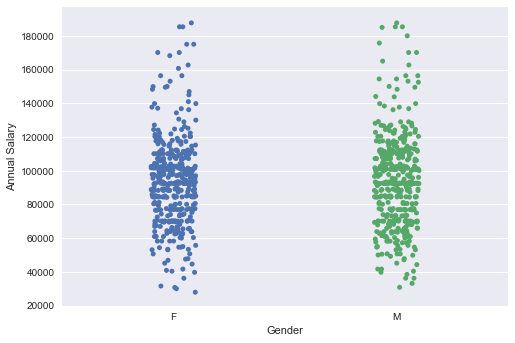

In [26]:
plt.show()